In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import PolyCollection
from matplotlib.animation import FuncAnimation

In [3]:
def process_file(file_name, sort_option = 'none'):
    
    df = pd.read_csv(file_name, delimiter='|', header=None, skiprows=1)
    Q = []
    seeds = []
    polygons = []
    data = []

    for index, row in df.iterrows():
    
        # get seedpoints
        seed_data = row[0]
        seed_points = np.array(seed_data.split(','), dtype=float)

        # get polygons for cells
        coords_data = row[1]
        poly = []
        for item in coords_data.split(';'):
            if item:
                points = item.split(",")
                points = np.array(points, dtype=float).reshape(-1, 2)
                poly.append(points[0])
        poly.append(poly[0])

        # get Q value or list of quantities
        q_data = row[2]
        if ',' in str(q_data):
            q_split = np.array(q_data.split(','), dtype=float)
        else:
            q_split = float(q_data)

        data.append((seed_points, poly, q_split))

    # sort data by x or y direction if needed
    if sort_option == 'x':
        data.sort(key=lambda x: x[0][0])
    elif sort_option == 'y':
        data.sort(key=lambda x: x[0][1])

    seeds, polygons, Q = zip(*data)

    return np.array(seeds), list(polygons), np.array(Q)

### 2D-image

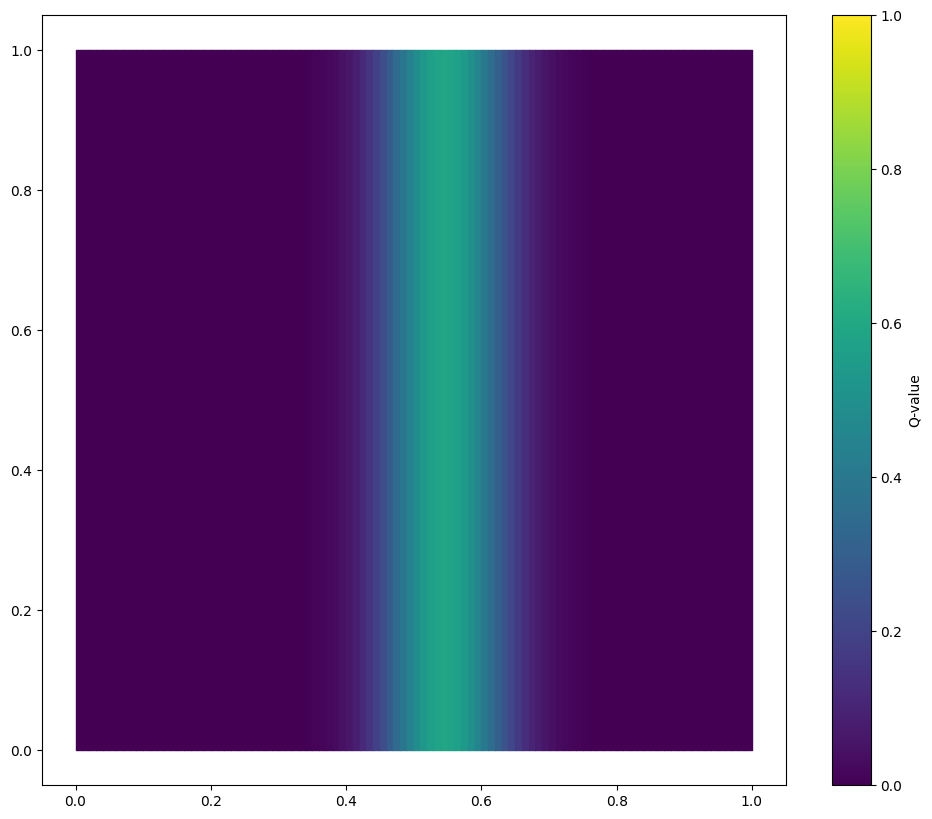

In [5]:
seed, polygons, Q = process_file('files/cmesh199.csv')


# plot mesh with Q
fig, ax = plt.subplots(figsize = (12, 10))
norm = mcolors.Normalize(vmin=0, vmax=1)
collection = PolyCollection(polygons, array=Q, cmap='viridis', norm=norm, edgecolor='face') # edgecolor = 'none' / 'face'
ax.add_collection(collection)
ax.autoscale_view()
cbar = fig.colorbar(collection, ax=ax)
cbar.set_label('Q-value')
plt.savefig('figures/image.png')
plt.show()

### 2D-animation

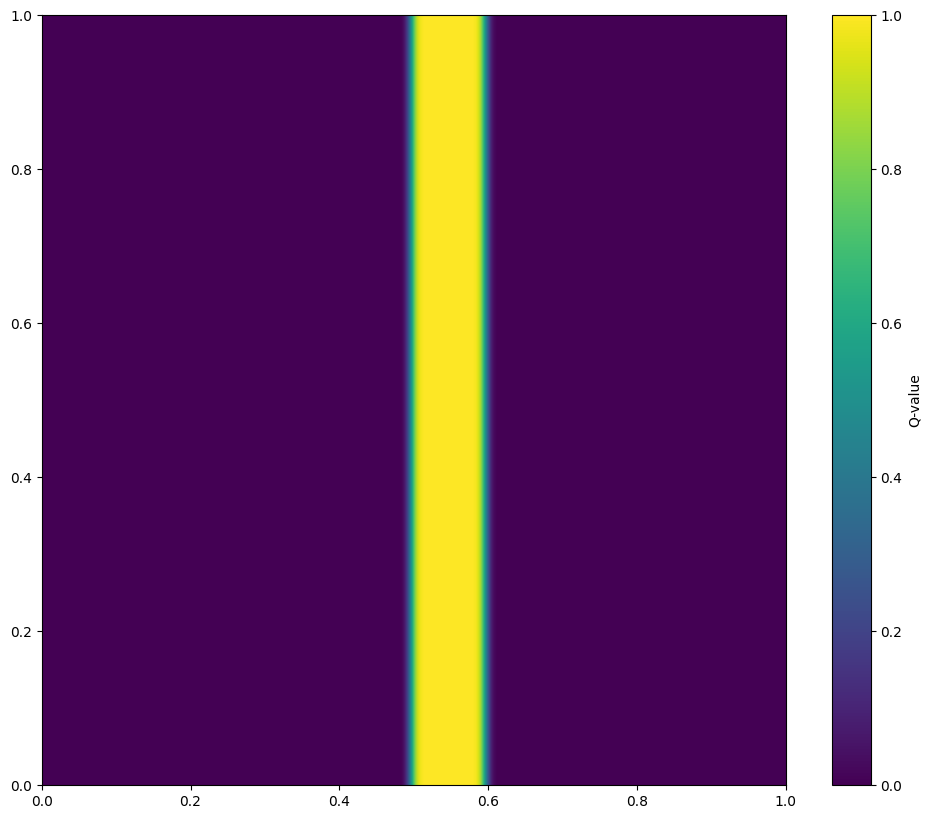

In [16]:
# define figure and axes
fig, ax = plt.subplots(figsize=(12, 10))
norm = mcolors.Normalize(vmin=0, vmax=1)
collection = PolyCollection([], array=[], cmap='viridis', norm=norm)
collection.set_edgecolor('face') # edgecolor = 'none' / 'face'
ax.add_collection(collection)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
#ax.set_title("Conway's Game of Life - Voronoi")
cbar = fig.colorbar(collection, ax=ax)
cbar.set_label('Q-value')


# animation update function
def update(frame):
    file_name = f"files/cmesh{frame}.csv"
    seeds, polygons, Q = process_file(file_name)
    collection.set_paths(polygons)
    collection.set_array(Q)
    return collection,

# animation
frames = range(0, 20000, 100)
fps = 30
ani = FuncAnimation(fig, update, frames=frames, blit=True, repeat=False)
ani.save('figures/animation.gif', fps=fps)
plt.show()


### 1D-plot

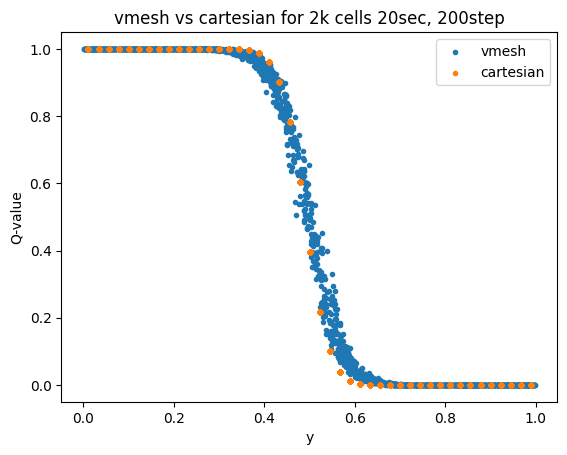

In [115]:
# 1D-plot of vmesh and cartesian Q values
seed_v, polygons_v, Q_v = process_file("files/vmesh199.csv", sort_option='y')
seed_c, polygons_c, Q_c = process_file("files/cmesh199.csv", sort_option='y')

plt.scatter(seed_v[:, 1], Q_v, marker = '.', label = 'vmesh')
plt.scatter(seed_c[:, 1], Q_c, marker = '.', label = 'cartesian')
plt.title("vmesh vs cartesian for 2k cells 20sec, 200step")
plt.xlabel("y")
plt.ylabel("Q-value")
plt.legend()
plt.show()

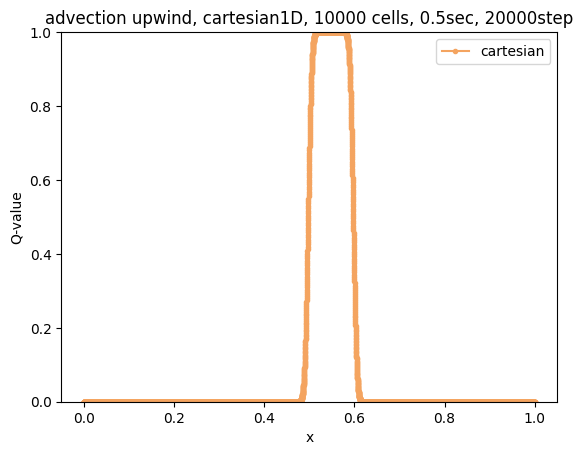

In [15]:
# functions to either plot 1D-animation of Q over time or binned 1D-animation of Q on 2D mesh over time

def process_and_plot(file_path, sort_option, bin_size = 45):
    seed, polygons, Q = process_file(file_path, sort_option=sort_option)
    #avg_seed = [np.mean(seed[i:i+bin_size, 0]) for i in range(0, int(len(seed[:, 0])), bin_size)]
    #avg_Q = [np.mean(Q[i:i+bin_size]) for i in range(0, int(len(Q)), bin_size)]
    return seed[:, 0], Q, #avg_seed, avg_Q


def update(frame):
    plt.cla()
    #y_v, Q_v = process_and_plot(f"files/vmesh{frame}.csv", 'y')#, avg_y_v, avg_Q_v = process_and_plot(f"files/vmesh{frame}.csv", 'y')
    y_c, Q_c = process_and_plot(f"files/cmesh{frame}.csv", 'y')#, avg_y_c, avg_Q_c = process_and_plot(f"files/cmesh{frame}.csv", 'y')
    #plt.plot(y_v, Q_v, marker='.', label = 'vmesh', color = 'cornflowerblue')
    #plt.plot(avg_y_v, avg_Q_v, color = 'tab:blue', label = 'binned vmesh')
    plt.plot(y_c, Q_c, marker='.', label = 'cartesian', color = 'sandybrown')
    #plt.plot(avg_y_c, avg_Q_c, color = 'tab:orange', label = 'binned cartesian')
    plt.title(f"advection upwind, cartesian1D, 10000 cells, 0.5sec, 20000step")
    plt.xlabel("x")
    plt.ylabel("Q-value")
    plt.ylim(0, 1)
    plt.legend()

fig, ax = plt.subplots()
ani = FuncAnimation(fig, update, frames=range(0, 20000, 100), repeat=True)
ani.save('figures/1d_animation.gif', fps=fps)
plt.show()


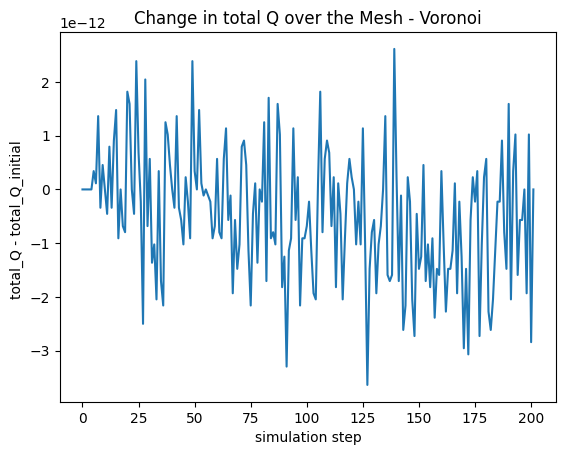

In [201]:
# plot difference in total Q over simulation steps
df = pd.read_csv('files/total_Q_diff.csv', decimal=',', header=None)
diff_Q = np.nan_to_num(df.astype(float).to_numpy().flatten())

plt.plot(diff_Q)
plt.title("Change in total Q over the Mesh - Voronoi")
plt.xlabel('simulation step')
plt.ylabel('total_Q - total_Q_initial ')
plt.savefig("figures/delta_Q_total.png")
plt.show()